# 01 - Latest Prices Analysis
## Q: "Berapa harga terkini untuk 10 komoditas pokok di 37 provinsi, dan bagaimana perbandingannya dengan rata-rata nasional?"

---

## Setup

In [5]:
# Add project root to Python path
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

print(f"📁 Project root: {project_root}")

📁 Project root: d:\nusantara_food


In [6]:
# Standard imports
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Our custom utilities
from src.data_analysis.utils import (
    DataLoader, 
    DataSaver, 
    load_data, 
    save_csv,
    setup_plot_style,
    check_missing_values
)

from src.data_analysis.config import (
    INTERIM_DIR, 
    PROCESSED_DIR, 
    FIGURES_DIR,
    DEFAULT_COMMODITIES,
    MARKET_TYPES
)

# Setup plotting style
setup_plot_style()
%matplotlib inline

print("✅ Imports complete!")
print(f"\n📁 Output directories:")
print(f"   Interim: {INTERIM_DIR}")
print(f"   Processed: {PROCESSED_DIR}")
print(f"   Figures: {FIGURES_DIR}")

✅ Imports complete!

📁 Output directories:
   Interim: d:\nusantara_food\data\interim
   Processed: d:\nusantara_food\data\processed
   Figures: d:\nusantara_food\reports\figures


## Configuration

In [7]:
SQL_FILE = 'queries/q1_latest_prices.sql'
OUTPUT_CSV = 'latest_prices_analyzed.csv'

---
## Your Analysis Here

Use the cells below for your data extraction logic.

In [ ]:
# Method 1: Load SQL from file (RECOMMENDED!)
with open(project_root / SQL_FILE, 'r') as f:
    query = f.read()

df = load_data(query)  # ← Template function runs SQL!

print(f"✅ Loaded {len(df)} rows")
print(f"📅 Data date: {df['tanggal'].iloc[0]}")
df.head()

✅ Loaded 42 rows
📅 Data date: 2025-12-03


d:\nusantara_food\src\data_analysis\utils.py:110: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, self.conn)


,province_name,region,commodity_name,harga,national_avg,deviation_pct,tanggal
0,Papua,Papua,Bawang Merah,63150.0,51412.5,22.83,2025-12-03
1,Gorontalo,Sulawesi,Bawang Merah,60000.0,51412.5,16.70,2025-12-03
2,Kepulauan Riau,Sumatra,Bawang Merah,41250.0,51412.5,-19.77,2025-12-03
3,Lampung,Sumatra,Bawang Merah,41250.0,51412.5,-19.77,2025-12-03
4,Papua,Papua,Bawang Putih,52900.0,41225.0,28.32,2025-12-03


In [10]:
# Data Verification
# Check for missing provinces
expected_provinces = 37
actual_provinces = df['province_name'].nunique()
print(f"Provinces: {actual_provinces}/{expected_provinces}")

# Check commodities
expected_commodities = 10
actual_commodities = df['commodity_name'].nunique()
print(f"Commodities: {actual_commodities}/{expected_commodities}")

# Any nulls?
null_count = df['harga'].isna().sum()
print(f"Null prices: {null_count}")


Provinces: 6/37
Commodities: 10/10
Null prices: 0


In [11]:
print("📊 National Summary:")
summary = df.groupby('commodity_name')['harga'].agg(['mean', 'min', 'max', 'std'])
print(summary)

📊 National Summary:
                    mean       min       max           std
commodity_name                                            
Bawang Merah     51412.5   41250.0   63150.0  11804.898348
Bawang Putih     41225.0   35750.0   52900.0   8011.086069
Beras            15475.0   14300.0   18200.0   1414.125171
Cabai Merah      66287.5   35000.0   92500.0  26896.665686
Cabai Rawit      67037.5   55000.0   86150.0  14609.835443
Daging Ayam      39412.5   37500.0   43400.0   2707.512696
Daging Sapi     134687.5  120000.0  151250.0  13783.104089
Gula Pasir       18800.0   16150.0   22100.0   2494.994990
Minyak Goreng    21975.0   18450.0   26050.0   3520.534997
Telur Ayam       33887.5   29000.0   40000.0   4771.508322


🎨 Saved figure: d:\nusantara_food\reports\figures\heatmap_latest_prices.png


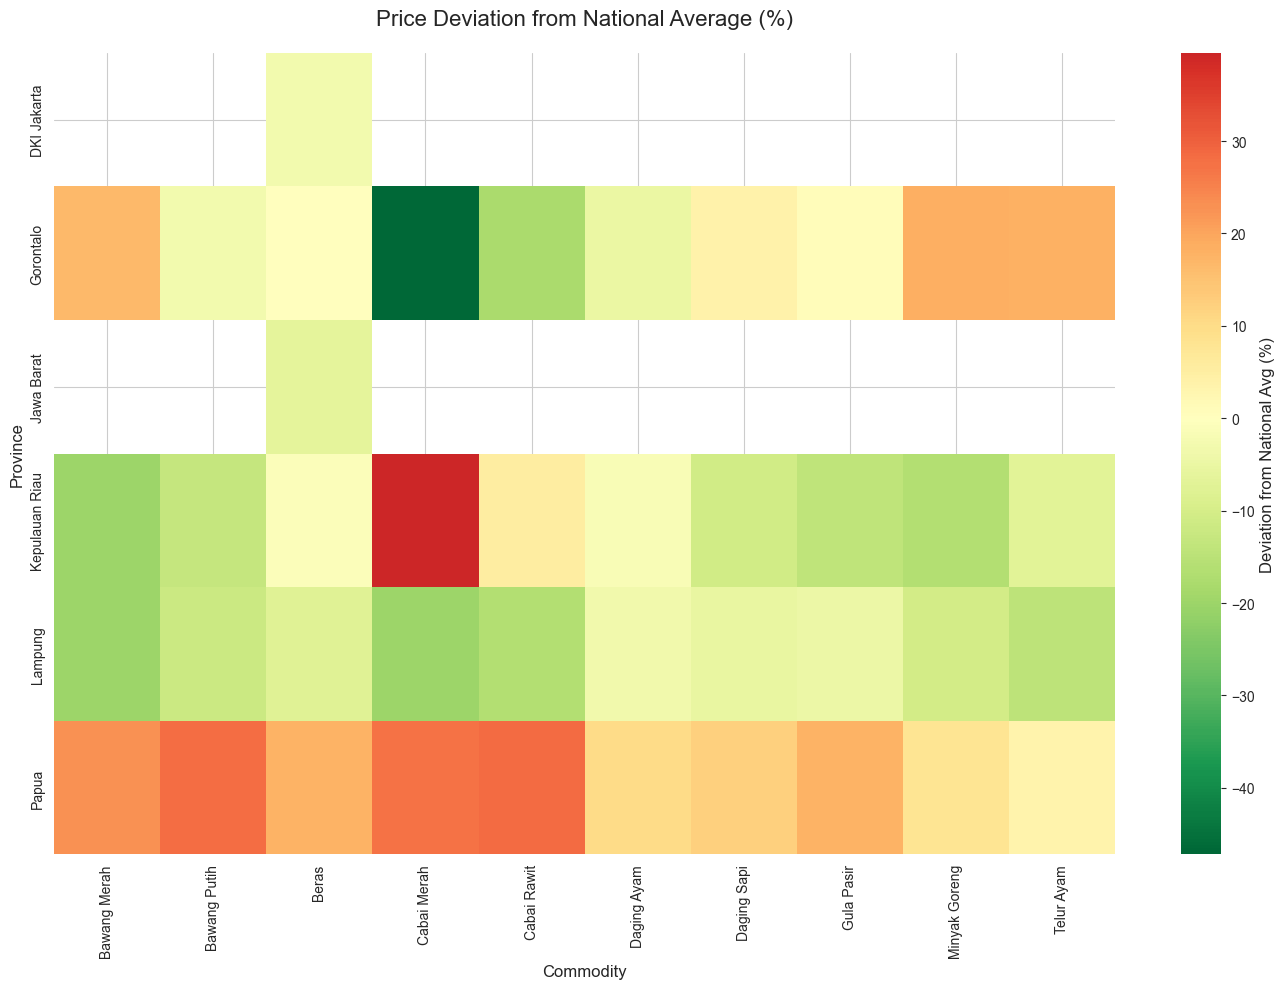

In [13]:
# Visualization
# Create pivot for heatmap
pivot = df.pivot(
    index='province_name', 
    columns='commodity_name', 
    values='deviation_pct'
)

# Plot
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(
    pivot, 
    annot=False,
    fmt='.1f',
    cmap='RdYlGn_r',  # Red = expensive, Green = cheap
    center=0,
    ax=ax,
    cbar_kws={'label': 'Deviation from National Avg (%)'}
)
ax.set_title('Price Deviation from National Average (%)', fontsize=16, pad=20)
ax.set_xlabel('Commodity', fontsize=12)
ax.set_ylabel('Province', fontsize=12)

plt.tight_layout()

# Save using template function!
saver = DataSaver()
saver.save_figure(fig, 'heatmap_latest_prices.png', dpi=300)
# ✅ Auto-saved to: reports/figures/heatmap_latest_prices.png

plt.show()

🎨 Saved figure: d:\nusantara_food\reports\figures\top10_rice_prices.png


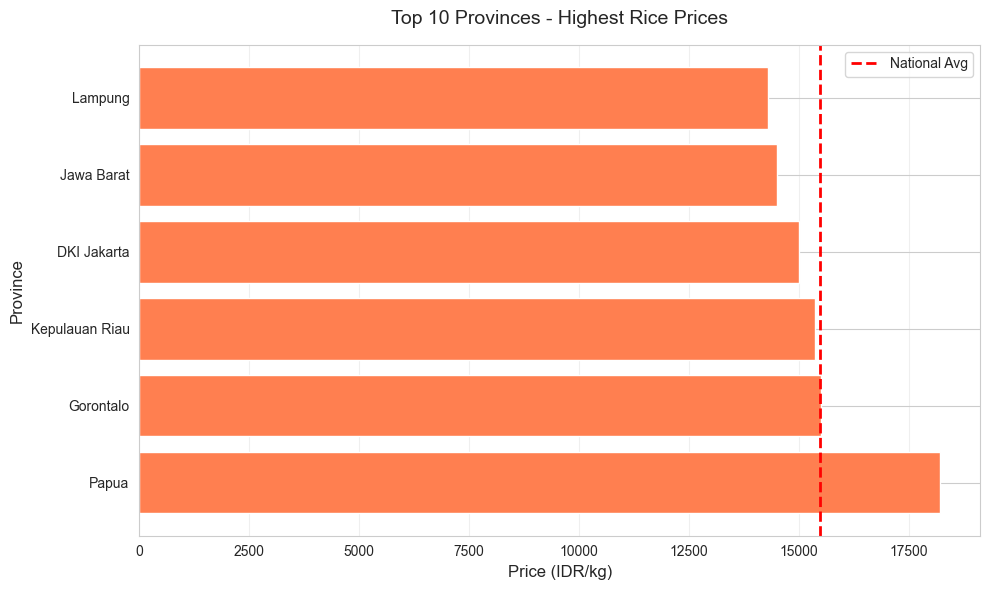

In [15]:
# Visualization 2 - Top 10 Most Expensive (Beras)
df_beras = df[df['commodity_name'] == 'Beras'].copy()
df_beras = df_beras.sort_values('harga', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(
    df_beras.head(10)['province_name'], 
    df_beras.head(10)['harga'],
    color='coral'
)

# Add national average line
national_avg = df_beras['national_avg'].iloc[0]
ax.axvline(national_avg, color='red', linestyle='--', linewidth=2, label='National Avg')

ax.set_xlabel('Price (IDR/kg)', fontsize=12)
ax.set_ylabel('Province', fontsize=12)
ax.set_title('Top 10 Provinces - Highest Rice Prices', fontsize=14, pad=15)
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
saver.save_figure(fig, 'top10_rice_prices.png')
plt.show()

---
## Save Results

In [16]:
# Save to processed folder
save_csv(df, OUTPUT_CSV, processed=True)
# ✅ Auto-saved to: data/processed/latest_prices_analyzed.csv

print("✅ Analysis complete!")
print(f"📊 Data saved to: {PROCESSED_DIR / OUTPUT_CSV}")
print(f"🎨 Figures saved to: {FIGURES_DIR}")

💾 Saved processed data: d:\nusantara_food\data\processed\latest_prices_analyzed.csv
✅ Analysis complete!
📊 Data saved to: d:\nusantara_food\data\processed\latest_prices_analyzed.csv
🎨 Figures saved to: d:\nusantara_food\reports\figures
